# install

### Install Lightning 2.0 

In [1]:
%pip install -qqq lightning
%pip install -qqq timm torchmetrics wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.5/553.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# import

In [2]:
import os
import time
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# torchvision
import torchvision
from torchvision import transforms, datasets

# wandb
import wandb
from lightning.pytorch.loggers import WandbLogger

# torchmetrics
import torchmetrics

# timm
import timm
from timm import create_model

# import Pytorch Lightning 2.0 
import lightning as L

# Fabric
from lightning.fabric import Fabric

# Config

In [3]:
config= {'model_name':'resnet18', 
         'seed': 2023,
         'bs': 32,
         'n_epochs': 10,
         'lr': 1e-3,
         'is_compiled': True, 
         'mode': 'default',
        #  'strategy': "auto",
         }

# Ramdom SEED

In [4]:
L.seed_everything(config['seed'])

INFO: Global seed set to 2023
INFO:lightning.fabric.utilities.seed:Global seed set to 2023


2023

# LitModel

In [5]:
class LitModel(L.LightningModule):
    def __init__(self, model_name, is_compiled, mode =None, batch_size = 32, lr = 1e-3):
        super().__init__()
        self.model = self.get_model(model_name, is_compiled, mode)
        self.batch_size = batch_size
        self.lr = lr

        # Lightning 2.0
        self.losses = []

        # Loss Function
        self.criterion = nn.CrossEntropyLoss()

        # torchmetrics modules
        self.f1 = torchmetrics.F1Score(task="multiclass", num_classes = 10)

    def forward(self, x):
        return self.model(x)

    def get_model(self, model_name, is_compiled, mode):
        
        model = create_model(model_name, pretrained=True, num_classes=10)

        if is_compiled:
            print(f"model_name: {model_name} | Compiled?: {is_compiled} | Compiled MODE: {mode}")
            compiled_model = torch.compile(model, mode = mode) #, backend="aot_ts_nvfuser") # backend="inductor")
            return compiled_model

        else:

            print(f"model_name: {model_name}")
            return model

    def shared_step(self, batch, mode):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        self.losses.append(loss)

        # F1 Score
        f1 = self.f1(logits, y)

        return {'loss': loss, "f1": f1}
        
    def shared_epoch_end(self, mode):

        loss = torch.stack(self.losses).mean().item()

        metrics = {f'{mode}_loss_epoch': loss, f'{mode}_f1_epoch': self.f1.compute()}
        
        self.log_dict(metrics, prog_bar=True)

        return {'loss': loss, "f1": self.f1.compute()}

        # Reset
        self.f1.reset()
        self.losses.clear()

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")
    
    # https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#validation-epoch-level-metrics
    def on_validation_epoch_end(self):
        return self.shared_epoch_end(mode = "valid")

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch,"train")

    # reference: https://github.com/Lightning-AI/lightning/pull/16520
    def on_train_epoch_end(self):
        return self.shared_epoch_end(mode = "train")

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def train_dataloader(self):
        # Return your dataloader for training
        train_set = datasets.CIFAR10(root="~/data", train=True, download=True, transform=transforms.ToTensor())
        train_loader = torch.utils.data.DataLoader(train_set, batch_size= self.batch_size, shuffle=True, num_workers= os.cpu_count())
        return train_loader
    
    def val_dataloader(self):
        val_set = datasets.CIFAR10(root="~/val_data", train=False, download=True, transform=transforms.ToTensor())
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=self.batch_size, shuffle=False, num_workers= os.cpu_count())
        return val_loader

# Fabric launch

In [6]:
# fabric = Fabric(accelerator="cuda", devices=8, strategy="ddp")
fabric = Fabric(accelerator= "auto", devices= "auto", strategy="auto")
fabric.launch()

# Model

In [7]:
# Instantiate the LightningModule
model = LitModel(model_name = config['model_name'],
                 is_compiled = config["is_compiled"],
                 mode = config["mode"],                  
                 batch_size = config['bs'],
                 lr = config['lr'])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


model_name: resnet18 | Compiled?: True | Compiled MODE: default


# Optimizer

In [8]:
# Get the optimizer(s) from the LightningModule
optimizer = model.configure_optimizers()

# train_loader, val_loader

In [9]:
train_loader = model.train_dataloader()
val_loader = model.val_dataloader()

100%|██████████| 170498071/170498071 [00:03<00:00, 44407008.59it/s]


Extracting /root/data/cifar-10-python.tar.gz to /root/data


100%|██████████| 170498071/170498071 [00:03<00:00, 46928296.49it/s]


Extracting /root/val_data/cifar-10-python.tar.gz to /root/val_data


## fabric.setup(model, optimizer)

In [10]:
model, optimizer = fabric.setup(model, optimizer)

## fabric.setup_dataloaders(train_loader, val_loader)

In [11]:
train_loader = fabric.setup_dataloaders(train_loader)
val_loader = fabric.setup_dataloaders(val_loader)
print("Loader with Fabric")

Loader with Fabric


# train_one_epoch

In [12]:
data = next(iter(train_loader))
data[0].shape, len(train_loader)

(torch.Size([32, 3, 32, 32]), 1563)

In [13]:
def train_one_epoch(model, 
                    dataloader, 
                    # loss_fn, 
                    optimizer,
                    # device, 
                    fabric,
                    epoch = 1):
    model.train()
    
    train_sum_loss, dataset_size = 0,  0 
    losses = []

    bar = tqdm(enumerate(dataloader), total= len(dataloader))
    
    ## dataloader from lightning: list
    for step, data in bar:
        batch = model.training_step(data, step)
        loss = batch['loss']
        losses.append(batch['loss'])
        
        # backprop
        optimizer.zero_grad()
        # loss.backward()
        fabric.backward(loss)
        optimizer.step()

        # Just for showing loss of "stacked batches" at tqdm progress bar
        bs = data[0].shape[0]
        train_sum_loss += (loss.item() * bs)
        dataset_size += bs
        train_epoch_loss = train_sum_loss / dataset_size
        
        bar.set_description(f"EP:[{epoch+1:02d}]|TL:[{train_epoch_loss:.3e}]|F1 Score:[{batch['f1']:.2f}]")
        
    # Epoch's Loss, other Metrics. 
    outputs = model.on_train_epoch_end()
    train_loss = outputs['loss']
    train_f1 = outputs['f1']

    print("Train of Epoch Loss: %.2f | F1 Score: %.2f" % (train_loss, train_f1))

    return train_loss, train_f1


# valid one epoch

In [14]:
@torch.no_grad()
def valid_one_epoch(model, 
                    dataloader, 
                    # loss_fn,
                    # device = device, 
                    epoch = 1):
    model.eval()
    
    valid_sum_loss, dataset_size = 0,  0 
    losses = []
    bar = tqdm(enumerate(dataloader), total= len(dataloader))
    
    with torch.no_grad():
        for step, data in bar:
            batch = model.training_step(data, step)
            loss = batch['loss']
            losses.append(batch['loss'])

            # Just for showing loss of "stacked batches" at tqdm progress bar
            bs = data[0].shape[0]
            valid_sum_loss += (loss.item() * bs)
            dataset_size += bs
            valid_epoch_loss = valid_sum_loss / dataset_size
            
            bar.set_description(f"EP:[{epoch+1:02d}]|VL:[{valid_epoch_loss:.3e}]|F1 Score:[{batch['f1']:.2f}]")
            
    # Epoch's Loss, other Metrics.         
    outputs = model.on_validation_epoch_end()
    valid_loss = outputs['loss']
    valid_f1 = outputs['f1']
    print("Valdation of Epoch Loss: %.2f | F1 Score: %.2f" % (valid_loss, valid_f1))

    return valid_loss, valid_f1


# Run Train

In [15]:
def run_train(model, 
              train_loader, 
              val_loader, 
            #   loss_fn, 
              optimizer, 
              fabric,
            #   device = device, 
              n_epochs = 100, 
              print_iter= 10,
              early_stop = 20
              ):
    
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    start = time.time()
    
    train_hs, valid_hs, train_f1s, valid_f1s = [], [], [], []
    lowest_loss, lowest_epoch = np.inf, np.inf
    
    
    
    for epoch in range(n_epochs):
        
        train_loss, train_f1 = train_one_epoch(model = model, 
                                                dataloader = train_loader, 
                                                # loss_fn = loss_fn,
                                                optimizer = optimizer,
                                                # device = device, 
                                                fabric = fabric,
                                                epoch = epoch)
        
        valid_loss, valid_f1 = valid_one_epoch(model = model, 
                                                dataloader = val_loader, 
                                                # loss_fn = loss_fn,
                                                # device = device, 
                                                epoch = epoch)
        print()
        train_hs.append(train_loss)
        train_f1s.append(train_f1)
        valid_hs.append(valid_loss)
        valid_f1s.append(valid_f1)

        # Log the metrics
        wandb.log({"train_loss_epoch": train_loss})
        wandb.log({"valid_loss_epoch": valid_loss})

        # # Log the metrics
        wandb.log({"train_f1_epoch": train_f1})
        wandb.log({"valid_f1_epoch": valid_f1})
        
        if (epoch + 1) % print_iter == 0:
            print()
            print(f"Ep:[{epoch+1}]|TL:{train_loss:.3e}|VL:{valid_loss:.3e}|LL:{lowest_loss:.3e}")
            print()

        # 'Lowest Loss' update by 'valid loss' 
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = epoch
            torch.save(model.state_dict(), './model.bin')
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch +1:
                print("There is no improvement during last %d epochs" % early_stop)
                break
                
    print()
    print("The Best Validation Loss= %.3e at %d Epoch" % (lowest_loss, lowest_epoch))
    
    # model load
    model.load_state_dict(torch.load('./model.bin'))
    
    # result
    result = dict()
    result["Train Loss"] = train_hs
    result["Valid Loss"] = valid_hs

    result["Train F1 Score"] = train_f1s
    result["Valid F1 Score"] = valid_f1s
        
    print()
    end = time.time()
    time_elapsed = end - start

    print('Training and Validation complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))

    return model, result
            

## wandb init()

In [16]:
################### wandb ######################
run = wandb.init(project='fabric_test', 
                 config=config,
                 job_type='Train',
                 name = "[compiled] from_lightning_to_fabric",
                 anonymous='must'
                 )

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Let's train!

In [17]:
model, result = run_train(model = model, 
                          train_loader = train_loader, 
                          val_loader = val_loader, 
                        #   loss_fn = loss_fn, 
                          optimizer = optimizer, 
                          fabric = fabric,
                          n_epochs = config['n_epochs'], 
                          print_iter= 10,
                          early_stop = 20
                          )

EP:[01]|TL:[1.112e+00]|F1 Score:[0.75]: 100%|██████████| 1563/1563 [02:55<00:00,  8.89it/s]


Train of Epoch Loss: 1.11 | F1 Score: 0.63


EP:[01]|VL:[8.450e-01]|F1 Score:[0.62]: 100%|██████████| 313/313 [00:19<00:00, 15.71it/s]


Valdation of Epoch Loss: 1.07 | F1 Score: 0.64



EP:[02]|TL:[7.656e-01]|F1 Score:[0.88]: 100%|██████████| 1563/1563 [00:45<00:00, 34.38it/s]


Train of Epoch Loss: 0.93 | F1 Score: 0.69


EP:[02]|VL:[7.298e-01]|F1 Score:[0.81]: 100%|██████████| 313/313 [00:04<00:00, 63.68it/s]


Valdation of Epoch Loss: 0.91 | F1 Score: 0.69



EP:[03]|TL:[6.350e-01]|F1 Score:[0.88]: 100%|██████████| 1563/1563 [00:45<00:00, 34.25it/s]


Train of Epoch Loss: 0.83 | F1 Score: 0.72


EP:[03]|VL:[7.189e-01]|F1 Score:[0.69]: 100%|██████████| 313/313 [00:04<00:00, 73.58it/s]


Valdation of Epoch Loss: 0.83 | F1 Score: 0.72



EP:[04]|TL:[5.118e-01]|F1 Score:[0.94]: 100%|██████████| 1563/1563 [00:46<00:00, 33.72it/s]


Train of Epoch Loss: 0.76 | F1 Score: 0.75


EP:[04]|VL:[6.473e-01]|F1 Score:[0.75]: 100%|██████████| 313/313 [00:04<00:00, 73.97it/s]


Valdation of Epoch Loss: 0.75 | F1 Score: 0.75



EP:[05]|TL:[4.194e-01]|F1 Score:[1.00]: 100%|██████████| 1563/1563 [00:45<00:00, 33.99it/s]


Train of Epoch Loss: 0.70 | F1 Score: 0.77


EP:[05]|VL:[6.978e-01]|F1 Score:[0.75]: 100%|██████████| 313/313 [00:05<00:00, 56.54it/s]


Valdation of Epoch Loss: 0.70 | F1 Score: 0.77



EP:[06]|TL:[3.394e-01]|F1 Score:[0.94]: 100%|██████████| 1563/1563 [00:45<00:00, 34.38it/s]


Train of Epoch Loss: 0.64 | F1 Score: 0.78


EP:[06]|VL:[6.370e-01]|F1 Score:[0.69]: 100%|██████████| 313/313 [00:05<00:00, 54.66it/s]


Valdation of Epoch Loss: 0.64 | F1 Score: 0.78



EP:[07]|TL:[2.698e-01]|F1 Score:[0.81]: 100%|██████████| 1563/1563 [00:45<00:00, 34.17it/s]


Train of Epoch Loss: 0.60 | F1 Score: 0.80


EP:[07]|VL:[6.899e-01]|F1 Score:[0.75]: 100%|██████████| 313/313 [00:04<00:00, 73.38it/s]


Valdation of Epoch Loss: 0.60 | F1 Score: 0.80



EP:[08]|TL:[2.185e-01]|F1 Score:[0.94]: 100%|██████████| 1563/1563 [00:46<00:00, 33.97it/s]


Train of Epoch Loss: 0.56 | F1 Score: 0.81


EP:[08]|VL:[6.715e-01]|F1 Score:[0.75]: 100%|██████████| 313/313 [00:04<00:00, 74.44it/s]


Valdation of Epoch Loss: 0.56 | F1 Score: 0.81



EP:[09]|TL:[1.850e-01]|F1 Score:[0.94]: 100%|██████████| 1563/1563 [00:46<00:00, 33.90it/s]


Train of Epoch Loss: 0.53 | F1 Score: 0.82


EP:[09]|VL:[7.522e-01]|F1 Score:[0.81]: 100%|██████████| 313/313 [00:04<00:00, 69.26it/s]


Valdation of Epoch Loss: 0.53 | F1 Score: 0.82



EP:[10]|TL:[1.532e-01]|F1 Score:[1.00]: 100%|██████████| 1563/1563 [00:45<00:00, 34.48it/s]


Train of Epoch Loss: 0.50 | F1 Score: 0.83


EP:[10]|VL:[7.023e-01]|F1 Score:[0.75]: 100%|██████████| 313/313 [00:06<00:00, 48.76it/s]


Valdation of Epoch Loss: 0.50 | F1 Score: 0.83


Ep:[10]|TL:4.990e-01|VL:5.024e-01|LL:5.310e-01


The Best Validation Loss= 5.024e-01 at 9 Epoch

Training and Validation complete in 0h 10m 54s


# Visualization

In [18]:
################## Visualize #########################   
def make_plot(result, stage = "Loss"):

    plot_from = 0

    trains = f"Train {stage}"
    valids = f"Valid {stage}"

    plt.figure(figsize=(10, 6))
    
    plt.title(f"Train/Valid {stage} History", fontsize = 20)

    ## Modified for converting Type
    if type(result[trains][0]) == torch.Tensor:
        result[trains] = [num.detach().cpu().item() for num in result[trains]]
        result[valids] = [num.detach().cpu().item() for num in result[valids]]

    plt.plot(
        range(0, len(result[trains][plot_from:])), 
        result[trains][plot_from:], 
        label = trains
        )

    plt.plot(
        range(0, len(result[valids][plot_from:])), 
        result[valids][plot_from:], 
        label = valids
        )

    plt.legend()
    if stage == "loss":
        plt.yscale('log')
    plt.grid(True)
    plt.show()

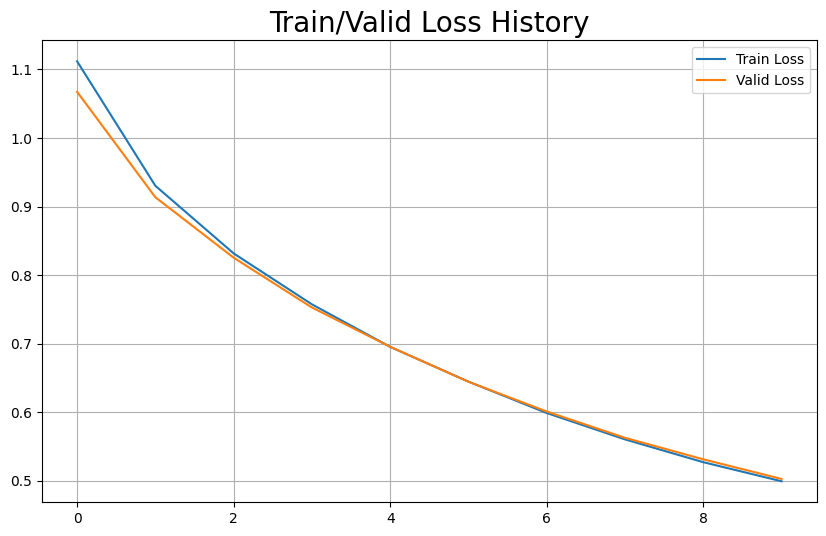

In [19]:
make_plot(result, stage = "Loss")

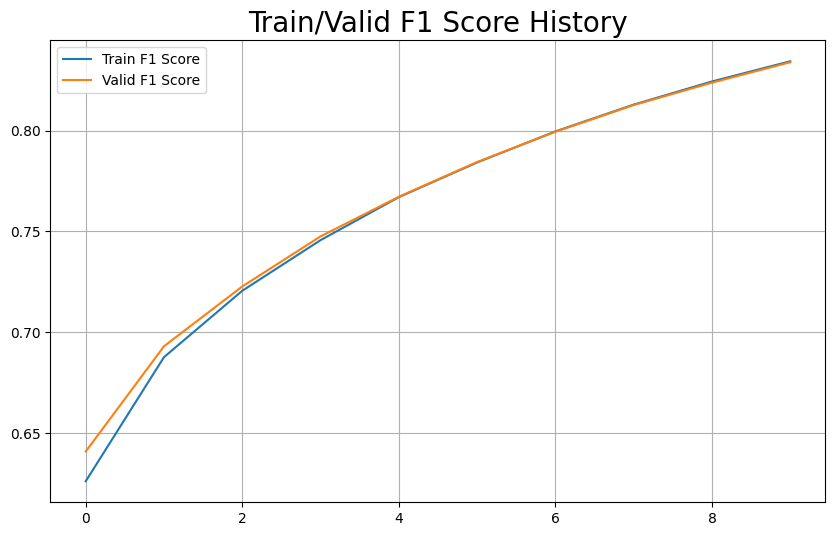

In [20]:
make_plot(result, stage = "F1 Score")

## wandb finish

In [21]:
############ wandb.finish() #################
run.finish()

train_f1_epoch,▁▃▄▅▆▆▇▇██
train_loss_epoch,█▆▅▄▃▃▂▂▁▁
valid_f1_epoch,▁▃▄▅▆▆▇▇██
valid_loss_epoch,█▆▅▄▃▃▂▂▁▁
train_f1_epoch,0.83439
train_loss_epoch,0.499
valid_f1_epoch,0.83392
valid_loss_epoch,0.5024
